In [1]:
import verse

/home/gokul/Desktop/verse-research/verse_research_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import Tuple, List

import numpy as np
from scipy.integrate import ode
import torch

# from tutorial_utils import drone_params
from verse import BaseAgent
from verse import LaneMap
from verse.map.lane_map_3d import LaneMap_3d
from verse.analysis.utils import wrap_to_pi
from verse.analysis.analysis_tree import TraceType

from numba import njit

In [3]:

def make_random_input(seed, intruder_can_turn=True, num_inputs=100):
    """make a random input for the system"""

    np.random.seed(seed) # deterministic random numbers

    # state vector is: x, y, theta, x2, y2, theta2, time
    init_vec = np.zeros(7)
    init_vec[2] = np.pi / 2 # ownship moving up initially

    radius = 10000 + np.random.random() * 55000 # [10000, 65000]
    angle = np.random.random() * 2 * np.pi
    int_x = radius * np.cos(angle)
    int_y = radius * np.sin(angle)
    int_heading = np.random.random() * 2 * np.pi

    init_vec[3] = int_x
    init_vec[4] = int_y
    init_vec[5] = int_heading

    # intruder commands for every control period (0 to 4)
    if intruder_can_turn:
        cmd_list = []

        for _ in range(num_inputs):
            cmd_list.append(np.random.randint(5))
    else:
        cmd_list = [0] * num_inputs

    # generate random valid velocities
    #init_velo = [np.random.randint(100, 1146),
    #             np.random.randint(60, 1146)]
    init_velo = [np.random.randint(100, 1200),
                 np.random.randint(0, 1200)]

    return init_vec, cmd_list, init_velo


In [4]:
from dl_acas import CraftMode

init_vec, cmd_list, init_velo = make_random_input(seed=671, intruder_can_turn=False)
x1 = init_vec[0]
y1 = init_vec[1]
theta1 = init_vec[2]
x2 = init_vec[3]
y2 = init_vec[4]
theta2 = init_vec[5]
random_attr = init_vec[6]
ego_velo = init_velo[0]
int_velo = init_velo[1]
ego_mode = CraftMode.Coc
int_mode = CraftMode.Coc


In [5]:
decisions = np.load('commands_671.npy')
decisions = decisions.tolist()

In [6]:
from aircraft_agent import AircraftAgent



In [7]:
from verse.scenario import Scenario
from verse.scenario import ScenarioConfig

from tutorial_map import M4

scenario = Scenario()
# scenario.set_map(M4())

In [8]:
ac1 = AircraftAgent("aircraft1", file_name="dl_acas.py", initial_mode=ego_mode, velo=ego_velo)

ac1.set_initial(
    [[-0.5, -0.5, -0.5, 0.0], [0.5, 0.5, 0.5, 0.0]], ([CraftMode.Coc]),
)
ac2 = AircraftAgent("aircraft2", file_name="dl_acas.py", initial_mode=int_mode, velo=int_velo)

ac2.set_initial(
    [[9, 9, 9, 0.0], [10, 10, 10, 0.0]], ([CraftMode.Coc]),
)

scenario.add_agent(ac1)
scenario.add_agent(ac2)

/home/gokul/Desktop/verse-research/acasxu_verse_int/verse/parser/parser.py:933: UserWarning: Effects of this call will not be included in the result: "logging.basicConfig(filename='myapp.log', level=logging.INFO)"
  warnings.warn(


In [9]:
from tutorial_sensor import DefaultSensor

scenario.set_sensor(DefaultSensor())

In [10]:
traces_simu = scenario.simulate(60, 0.2)
traces_veri = scenario.verify(60, 0.2)

2023-11-07 16:09:14,228	INFO worker.py:1625 -- Started a local Ray instance.


(simulate_one pid=447967) node 0 start: 0
(simulate_one pid=447967) 1
(simulate_one pid=447967) node 1 start: 3.0
(compute_full_reachtube_step pid=447967) node 0 start: 0
(compute_full_reachtube_step pid=447967) {'aircraft1': ('Coc',), 'aircraft2': ('Coc',)}
(compute_full_reachtube_step pid=447967) 0
(compute_full_reachtube_step pid=447967) aircraft1 None Coc Strong_right -> None
(compute_full_reachtube_step pid=447967) node 1 start: 2.2
(compute_full_reachtube_step pid=447967) {'aircraft1': ('Strong_right',), 'aircraft2': ('Coc',)}


In [11]:
from verse.plotter.plotter3D import *
import pyvista as pv
import warnings

warnings.filterwarnings("ignore")

from verse.plotter.plotter2D import *
import plotly.graph_objects as go

fig = go.Figure()
fig = reachtube_tree(traces_veri, None, fig, 1, 3)
fig.show()

# pv.set_jupyter_backend(None)
# fig = pv.Plotter()
# # fig = plot3dMap(M4(), ax=fig)
# fig = plot3dReachtube(traces_veri, "aircraft1", 1, 2, 3, color="r", ax=fig)
# fig = plot3dReachtube(traces_veri, "aircraft2", 1, 2, 3, color="b", ax=fig)
# fig.set_background("#e0e0e0")
# fig.show()

TypeError: 'AnalysisTree' object is not iterable

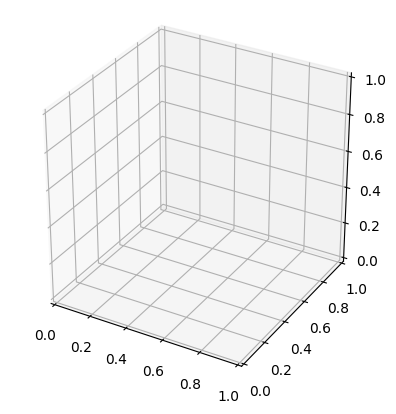

In [13]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# import numpy as np
# import polytope as pc

# # ... (other function definitions)

# def plot3dReachtubeMatplotlib(traces, agent_id, x_dim, y_dim, z_dim, ax, color='red', alpha=0.5):
#     for node in traces:  # Assuming 'traces' is an iterable of nodes
#         trace = node.trace[agent_id]  # Access the agent's trace
#         for i in range(0, len(trace), 2):
#             lb = trace[i]
#             ub = trace[i + 1]
#             box = np.array([[lb[x_dim], lb[y_dim], lb[z_dim]], [ub[x_dim], ub[y_dim], ub[z_dim]]]).T
#             poly = pc.box2poly(box)
#             vertices = pc.extreme(poly)
#             hull = pc.qhull.ConvexHull(vertices)
#             for simplex in hull.simplices:
#                 simplex = np.append(simplex, simplex[0])  # Close the polytope
#                 ax.add_collection3d(Poly3DCollection([vertices[simplex]], facecolors=color, edgecolors='k', alpha=alpha))
#     return ax

# # Usage
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.set_box_aspect([1,1,1])  # Set equal aspect ratio

# # Call the function with your data
# # You need to replace 'traces_veri' with the actual data structure that contains your trajectories.
# ax = plot3dReachtubeMatplotlib(traces_veri, "aircraft1", 1, 2, 3, ax=ax, color='red', alpha=0.5)
# ax = plot3dReachtubeMatplotlib(traces_veri, "aircraft2", 1, 2, 3, ax=ax, color='blue', alpha=0.5)

# # Set the background and show the plot
# ax.set_facecolor('#e0e0e0')
# plt.show()
